(groups_comparison_notebook)=
# Confronto tra due (o più) gruppi

L'obiettivo di questo capitolo è di ampliare la discussione del capitolo {ref}`bayes_one_mean_notebook`, affrontando il confronto tra le medie di due o più gruppi indipendenti. In particolare, esamineremo i prior predictive checks, ovvero verificheremo che le assunzioni del modello siano coerenti con i dati osservati. Per cominciare, caricheremo le librerie necessarie.

In [2]:
from pymc import HalfNormal, HalfCauchy, Model, Normal, sample
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.constants import golden
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [3]:
%matplotlib inline

SEED = 42
rng = np.random.default_rng(SEED)
sns.set_theme()
sns.set_palette("colorblind")
plt.rc('figure', figsize=(5.0, 5.0/golden))

## Stima della media di un gruppo

Partiamo dal caso già discusso nel capitolo precedente, in cui abbiamo stimato l'incertezza relativa alla media di un singolo gruppo. Qui faremo uso dei dati relativi ai pinguini Palmer, che andremo a leggere da un file csv, escludendo quelli mancanti:

In [4]:
penguins = pd.read_csv("data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape


(333, 8)

Otteniamo in questo modo un DataFrame con 333 righe e 8 colonne. Calcoliamo la media del peso `body_mass_g` in funzione della specie:

In [5]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)


body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Otteniamo un grafico a violino per questi dati.

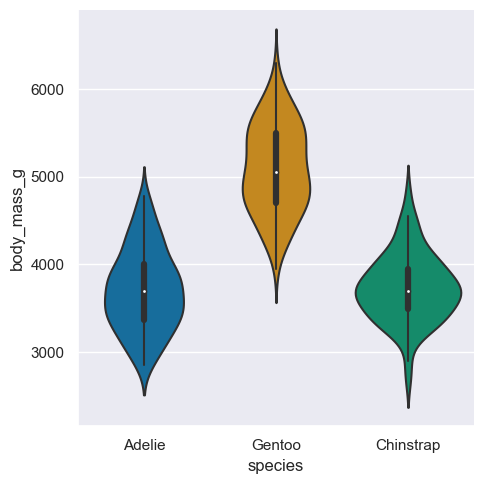

In [6]:
sns.catplot(kind="violin", data=penguins, x="species", y="body_mass_g")
plt.show()


Le descrizioni precedenti riguardano i dati del campione. In un altro campione i valori saranno diversi. Poniamoci dunque il problema di quantificare l'intertezza che abbiamo relativamente alla stima del peso delle tre specie di pinguini, sapendo che la stima attuale si basa solo su un piccolo campione di osservazioni.

Un modo per quantificare l'incertezza della nostra stima è quello di utilizzare i metodi bayesiani. 

Per fare questo abbiamo bisogno di fare riferimento ad un modello statistico tramite il quale sia possibile descrive la relazione tra osservazioni e parametri. Per il caso presente, descriviamo la distribuzione a posteriori dei parametri, alla luce dei dati, nel modo seguente:

$$
p(\mu, \sigma \mid y) \propto p(y \mid \mu, \sigma) p(\mu)p(\sigma),
$$

laddove per la verosimilianza useremo una densità Normale. La Normale dipende da due parametri, $\mu$ e $\sigma$. Abbiamo dunque bisogno di specificare le distribuzioni a priori di questi due parametri. Per $\mu$ useremo una distribuzione Normale: $\mu \sim \mathcal{N}(4000, 2000)$; per $\sigma$ useremo una Normale troncata (valori negativi sono impossibili): $\sigma \sim \mathcal{HN}(2000)$.

Iniziamo questo esempio selezionando unicamente i pinguini della specie Adelie. Per queste osservazioni, i valori della variabile `body_mass_g` sono i seguenti:

In [11]:
adelie_mass_obs = penguins[penguins["species"] == "Adelie"]["body_mass_g"]
print(adelie_mass_obs)


0      3750.0
1      3800.0
2      3250.0
4      3450.0
5      3650.0
        ...  
147    3475.0
148    3450.0
149    3750.0
150    3700.0
151    4000.0
Name: body_mass_g, Length: 146, dtype: float64


Implementiamo il modello descritto in precedenza usando PyMC. 

Prima di effettuare il campionamento della distribuzione a posteriori esaminiamo la distribuzione predittiva a priori per verificare l'adeguatezza della assunzioni relative alle distribuzioni a priori dei parametri. Per questo scopo, usiamo la funzione `pm.sample_prior_predictive()`. Generiamo 1000 valori casuli dalle distribuzioni a priori dei due parametri.

In [20]:
with pm.Model() as model_adelie_penguin_mass:
    sigma = pm.HalfNormal("sigma", sigma=1000)
    mu = pm.Normal("mu", 4000, 2000)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    idata1 = pm.sample_prior_predictive(samples=1000, random_seed=rng)


Sampling: [mass, mu, sigma]


Dall'oggetto inferenceData `idata1` recuperiamo i campioni delle distribuzioni a priori e li passiamo a `az.plot_trace()`:

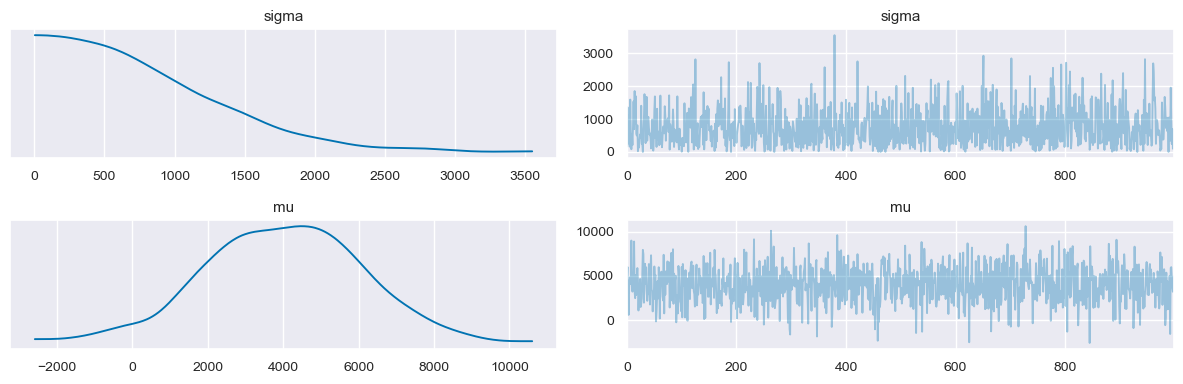

In [21]:
prior = idata1.prior
_ = az.plot_trace(prior)
plt.tight_layout()


Dall'esame delle distribuzioni a priori dei due parameti è evidente che non stiamo vincolando eccessivamente il campionamento della variabile `adelie_mass_obs`. Potremmo anzi avere scelto delle distribuzioni a priori troppo larghe, considerato che la distribuzione a priori per $\mu$ include anche valori negativi. Tuttavia, poiché questo è un modello semplice e abbiamo un discreto numero di osservazioni, non dobbiamo preoccuparci.  Passiamo dunque alla stima della distribuzione a posteriori.

In [22]:
with pm.Model() as model_adelie_penguin_mass:
    sigma = pm.HalfNormal("sigma", sigma=1000)
    mu = pm.Normal("mu", 4000, 2000)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    idata2 = pm.sample(3000, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.


Il KDE ploy e il rank plot della distribuzione a posteriori dei parametri del modello bayesiano servono come strumenti diagnostici visivi per aiutarci a capire se ci sono stati problemi durante il campionamento. Non vi sono evidenze di alcun problema.

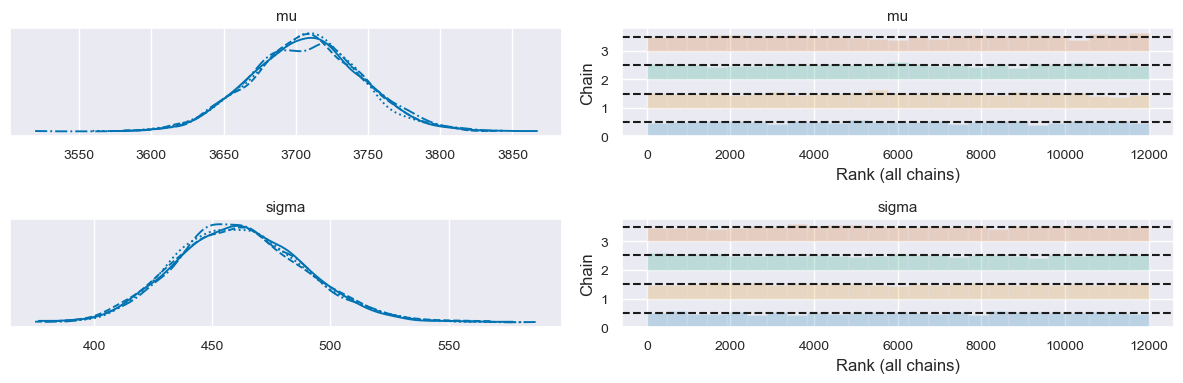

In [23]:
axes = az.plot_trace(idata2, divergences="bottom", kind="rank_bars")
plt.tight_layout()


Possiamo combinare le quattro catene. Un confronto tra la stima della distribuzione a posteriori e le stime puntuali dei due parametri che abbiamo ottenuto dal campione (linee verticali) è fornito nella figura seguente.

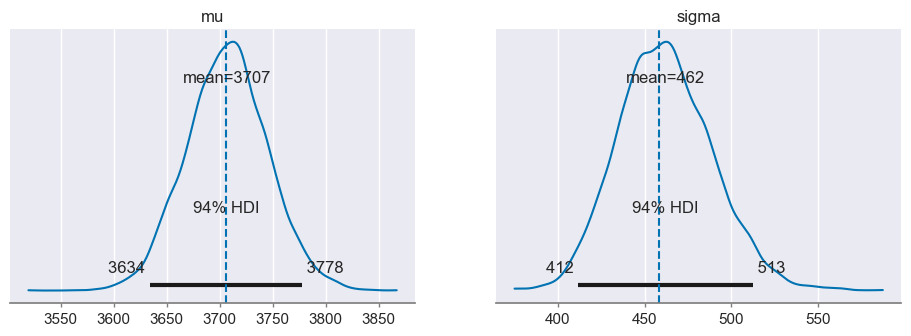

In [24]:
axes = az.plot_posterior(idata2, hdi_prob=0.94)

axes[0].axvline(3706.2, linestyle="--")
axes[1].axvline(458.6, linestyle="--")


Con la stima bayesiana otteniamo una distribuzione dei valori credibili dei parametri. Nelle distribuzioni a posteriori che abbiamo ottenuto per $\mu$ e $\sigma$, le stime campionarie rappresentano il valore più credibile, ma abbiamo imparato qual è la gamma di valori all'interno della quale ci possiamo aspettare che si trovi il "vero" valore del parametro (se venissero esaminati campioni diversi di osservazioni). L'intervallo di valori plausibili è piuttosto stretto per il parametro $\mu$ (diciamo, tra 3634 a 3778) ed anche per $\sigma$ (94% HDI: [412, 513]). 

Le due distribuzioni a posteriori descrivono l'incertezza che abbiamo relativamente ai veri valori di $\mu$ e $\sigma$, considerate le nostre credenze precedenti (che in questo caso corrispondevano a delle distribuzioni a priori debolmente informative, con l'unico scopo di regolarizzare i dati), i dati osservati e l'ipotesi che abbiamo fatto sul *meccanismo generatore dei dati*.

Un sommario numerico viene ottenuto con le seguenti istruzioni:

In [25]:
az.summary(idata2).round(2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3707.08,38.32,3634.13,3777.66,0.35,0.25,12042.0,8331.0,1.0
sigma,461.91,27.28,411.65,512.70,0.25,0.18,11681.0,8298.0,1.0


## Confonto tra più gruppi

Espandiamo la discussione precedente per affrontare il confronto tra le tre specie di pinguini. Per far ciò, è necessario creare una variabile categorica che indichi l'appartenenza di ciascuna osservazione del DataFrame ad un gruppo diverso, ovvero a una specie differente. A questo scopo usiamo il metodo `pd.Categorical`.

In [32]:
# pd.categorical makes it easy to index species below
all_species = pd.Categorical(penguins["species"])
print(all_species.dtype)


category


Eseguiamo ora il campionamento MCMC. Si noti che la specificazione del modello è quasi identica a quella che abbiamo usato nel caso di un solo gruppo. La differenza è che ora abbiamo aggiunto l'argomento `shape = 3` nella specificazione delle distribuzioni a priori. Inoltre, abbiamo specificato `mu[all_species.codes]` e `sigma[all_species.codes]` nella verosimiglianza così da indicare che le osservazioni appartengono a 3 gruppi diversi, così come specificato dalla variabile `all_species`.

In [33]:
with pm.Model() as model_penguin_mass_all_species:
    sigma = pm.HalfNormal("sigma", sigma=2000, shape=3)
    mu = pm.Normal("mu", 4000, 2000, shape=3)
    mass = pm.Normal(
        "mass",
        mu=mu[all_species.codes],
        sigma=sigma[all_species.codes],
        observed=penguins["body_mass_g"],
    )
    idata3 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Esaminiamo le distribuzioni a posteriori e le diagnostiche del campionamento.

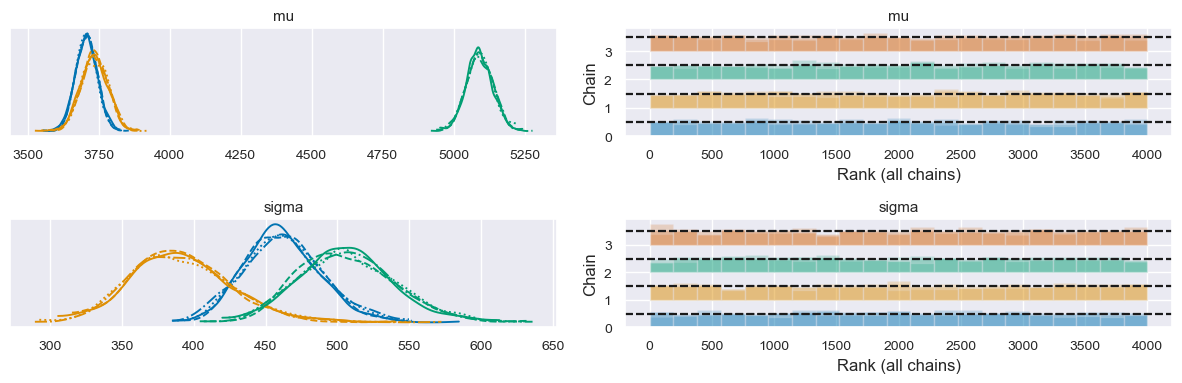

In [41]:
axes = az.plot_trace(idata3, divergences="bottom", kind="rank_bars")
plt.tight_layout()


Questa è una versione più compatta della figura precedente.

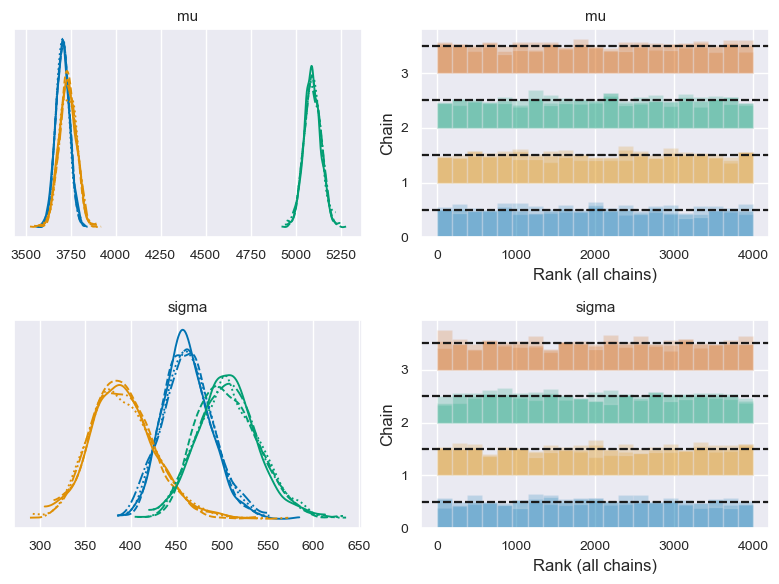

In [35]:
az.plot_trace(idata3, divergences="bottom", kind="rank_bars", figsize=(8, 6))
plt.tight_layout()


Abbiamo ottenuto tre distribuzioni a posteriori per ciascuno dei due parametri $\mu$ e $\sigma$, una distribuzione per ciascuna specie di pinguini.

Esaminiamo se le quattro catene hanno prodotto risultati diversi per il parametro $\mu$.

Text(0.5, 1.0, 'μ Mass Estimate: 94.0% HDI')

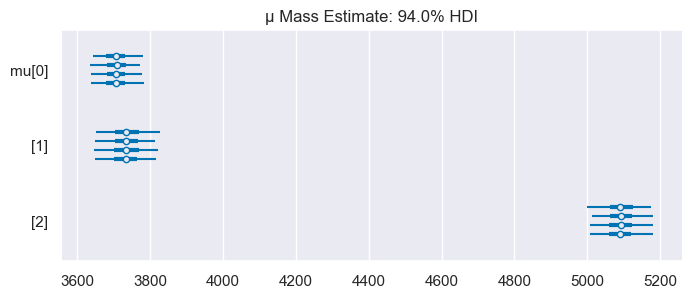

In [38]:
axes = az.plot_forest(idata3, var_names=["mu"], figsize=(8, 3))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")


Facciamo la stessa cosa per il parametro $\sigma$.

Text(0.5, 1.0, 'σ Mass Estimate: 94.0% HDI')

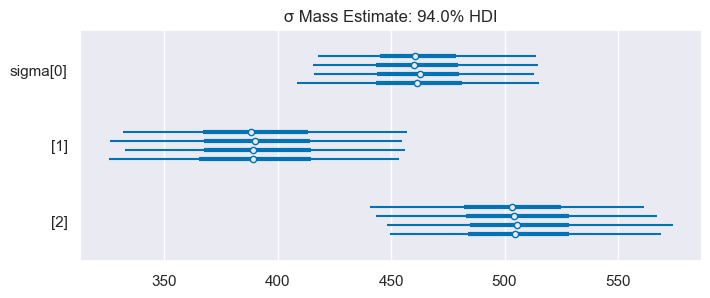

In [18]:
axes = az.plot_forest(idata3, var_names=["sigma"], figsize=(8, 3))
axes[0].set_title("σ Mass Estimate: 94.0% HDI")


Un sommario numerico delle distribuzioni a posteriori si ottiene nel modo seguente.

In [36]:
az.summary(idata3).round(2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],3706.17,37.63,3642.21,3783.94,0.47,0.33,6394.0,3034.0,1.0
mu[1],3734.10,47.97,3647.62,3820.64,0.67,0.47,5128.0,3438.0,1.0
mu[2],5092.16,46.80,5004.22,5178.53,0.68,0.48,4807.0,3032.0,1.0
sigma[0],462.18,26.79,411.62,511.61,0.36,0.25,5624.0,3227.0,1.0
sigma[1],391.23,35.06,328.90,458.90,0.45,0.32,5998.0,3250.0,1.0
sigma[2],506.64,33.52,441.50,566.76,0.46,0.33,5507.0,3183.0,1.0


Come si vede anche dalle figure precedenti, concludiamo che il peso dei pinguini Adelie e Chinstrap è molto simile, mentre i pinguini Gentoo tendono ad essere più pesanti. Le stime a posteriori della varianza indicano che vi è una maggiore variazione nel peso tra i pinguini Gentoo, seguita dalla variazione di peso tra i pinguini Adelie. I pinguini Chinstrap sono quelli più omogenei rispetto alla variazione di peso.

## Verifica di ipotesi bayesiana

Avendo trovato un campione della distribuzione a priori del parametro di interesse $\mu$ per ciascuna delle tre specie di pinguini, ci possiamo chiedere qual è la probabilità che un pinguino di una specie abbia un peso maggiore di un pinguino di un'altra specie. Avendo un campione casuale della distribuzione a posteriori è facile rispondere a questa domanda. Infatti, è sufficiente eseguire il confronto di interesse per molti valori del parametro e poi calcolare la media dei valori così trovati.

Iniziamo a recuperare i valori numerici della distribuzione a posteriori del parametro $\mu$ dall'oggetto `idata3`.

In [65]:
mu_post = idata3.posterior['mu']

Otteniamo in questo modo un array di dimensioni $4 \times 1000 \times 3$. L'indice 4 si riferisce alle catente, l'indice 1000 si riferisce al numero di campioni ottenuti, l'indice 3 si riferisce ai gruppi. 

In [69]:
mu_post.shape

(4, 1000, 3)

La sequenza dei gruppi segue l'ordine alfabetico dei nomi utilizzati per ciascuna specie. Dunque, l'indice 0 si riferisce ad Adelie, l'indice 1 si riferisce a Chinstrap e l'indice 2 si riferisce a Gentoo.

Per trovare la media a posteriori del parametro $\mu$ della specie Adelie prendiamo le osservazioni che si riferiscono a tutte le catene (:), a tutti i valori campionati (:) per il primo gruppo (0). La media a posteriori dei pinguini Adelie è dunque uguale a

In [83]:
print(mu_post[:, :, 0].mean())

<xarray.DataArray 'mu' ()>
array(3706.17087347)
Coordinates:
    mu_dim_0  int64 0


Per tutte e tre le specie (Adelie, Chinstrap, Gentoo) abbiamo

In [84]:
np.array([mu_post[:, :, 0].mean(), mu_post[:, :, 1].mean(), mu_post[:, :, 2].mean()])


array([3706.17087347, 3734.10426739, 5092.15554208])

Per verificare se l'ordinamento dei gruppi corrisponde alle specie ordinate in modo alfabetico, calcoliamo la stima a posteriori della deviazione standard delle tre specie. Sappiamo che la varianza è minore per Chinstrap, seguita poi da Adelie e infine da Gentoo. Verifichiamo.

In [85]:
sigma_post = idata3.posterior['sigma']
np.array([sigma_post[:, :, 0].mean(), sigma_post[:, :, 1].mean(), sigma_post[:, :, 2].mean()])


array([462.17510702, 391.23123977, 506.64351705])

I valori trovati confermano quello che ci aspettavamo. Ora che abbiamo capito come estrarre le stime a posteriori di un parametro per ciascun gruppo, possiamo passare al test di ipotesi bayesiano.
Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso maggiore di un pinguino Chinstrap.

In [86]:
np.mean([mu_post[:, :, 0] > mu_post[:, :, 1]])

0.32825

Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Gentoo.

In [87]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

1.0

Chiediamoci quale sia la probabilità che un pinguino Chinstrap abbia un peso minore di un pinguino Gentoo.

In [88]:
np.mean([mu_post[:, :, 1] < mu_post[:, :, 2]])

1.0

Consideriamo ora le deviazioni standard. Troviamo la probabilità che la varianza del peso dei pinguini Adelie sia minore di quella dei pinguini Chinstrap.

In [89]:
np.mean([sigma_post[:, :, 0] < sigma_post[:, :, 1]])

0.056

Troviamo la probabilità che la varianza del peso dei pinguini Adelie sia minore di quella dei pinguini Gentoo.

In [90]:
np.mean([sigma_post[:, :, 0] < sigma_post[:, :, 2]])

0.85575

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor